# clean up, integrate and aggregate NISKIN data

In [3]:
library(tidyverse, warn.conflicts = FALSE)

# library to read matlab data formats into R
library(reshape2)
library(lubridate)
library(viridis)
library(oce)

# set strings as factors to false
options(stringsAsFactors = FALSE)

# read NISKIN data (from csv)

In [52]:
niskin_ds <- read.csv("../../VeryNEWESTCariacoData/niskin_dtypes.csv")

In [53]:
niskin_ds$DATE <- paste(niskin_ds$Year,'-',niskin_ds$Month,'-',niskin_ds$Day, sep='')

In [54]:
# convert quality flags to readable format
niskin_ds$q_NO3_NO3_USF = as.numeric(substr(niskin_ds$q_NO3_NO3_USF, 3,3))
niskin_ds$q_NO2_USF = as.numeric(substr(niskin_ds$q_NO2_USF, 3,3))
niskin_ds$q_PO4_USF = as.numeric(substr(niskin_ds$q_PO4_USF, 3,3))
niskin_ds$q_SiO4_USF = as.numeric(substr(niskin_ds$q_SiO4_USF, 3,3))
niskin_ds$q_NO3_UDO = as.numeric(substr(niskin_ds$q_NO3_UDO, 3,3))
niskin_ds$q_PO4_UDO = as.numeric(substr(niskin_ds$q_PO4_UDO, 3,3))
niskin_ds$q_SiO4_UDO = as.numeric(substr(niskin_ds$q_SiO4_UDO, 3,3))
niskin_ds$q_Chlorophyll = as.numeric(substr(niskin_ds$q_Chlorophyll, 3,3))
niskin_ds$q_Phaeopigments = as.numeric(substr(niskin_ds$q_Phaeopigments, 3,3))
niskin_ds$q_PrimaryProductivity = as.numeric(substr(niskin_ds$q_PrimaryProductivity, 3,3))
niskin_ds$q_Temperature = as.numeric(substr(niskin_ds$q_Temperature, 3,3))
niskin_ds$q_pH_corrected = as.numeric(substr(niskin_ds$q_pH_corrected, 3,3))
niskin_ds$q_Salinity_bottles = as.numeric(substr(niskin_ds$q_Salinity_bottles, 3,3))
niskin_ds$q_Sigma_t = as.numeric(substr(niskin_ds$q_Sigma_t, 3,3))

In [55]:
# remove flagged measurements! ! ! !
niskin_ds[which(niskin_ds$q_NO3_NO3_USF>0),]$NO3_NO2_USF <- NA
#niskin_ds[which(niskin_ds$q_NO2_USF>0),]$N02_USF <- NA
niskin_ds[which(niskin_ds$q_PO4_USF>0),]$PO4_USF <- NA
niskin_ds[which(niskin_ds$q_SiO4_USF>0),]$SiO4_USF <- NA
niskin_ds[which(niskin_ds$q_Chlorophyll>0),]$Chlorophyll <- NA
niskin_ds[which(niskin_ds$q_Phaeopigments>0),]$Phaeopigments <- NA
niskin_ds[which(niskin_ds$q_PrimaryProductivity>0),]$PrimaryProductivity <- NA
niskin_ds[which(niskin_ds$q_Temperature>0),]$Temperature <- NA
niskin_ds[which(niskin_ds$q_pH_corrected>0),]$pH_corrected <- NA

niskin_ds[which(niskin_ds$q_NO3_UDO>0),]$NO3_UDO <- NA
#niskin_ds[which(niskin_ds$q_PO4_UDO>0),]$PO4_UDO <- NA
niskin_ds[which(niskin_ds$q_SiO4_UDO>0),]$q_SiO4_UDO <- NA

niskin_ds[which(niskin_ds$q_Salinity_bottles>0),]$Salinity_bottles <- NA

niskin_ds[which(niskin_ds$q_Sigma_t>0),]$Sigma_t <- NA

In [56]:
# additionally remove outliers
niskin_ds[which(niskin_ds$Chlorophyll>10),]$Chlorophyll <- NA


## plot nuts depth resolved
## check interpolation! remove outliers

In [44]:
which(niskin_ds$NO3_UDO>15,)

[1]   47   48   49   67   68  142  282  298  299  300  301  302  303  317  319
[16]  320  321  322 1584 1617 1677 1678 1679 1712 1715 1716 1717

[1]    8.22624 3335.00000
[1] 0.4854973


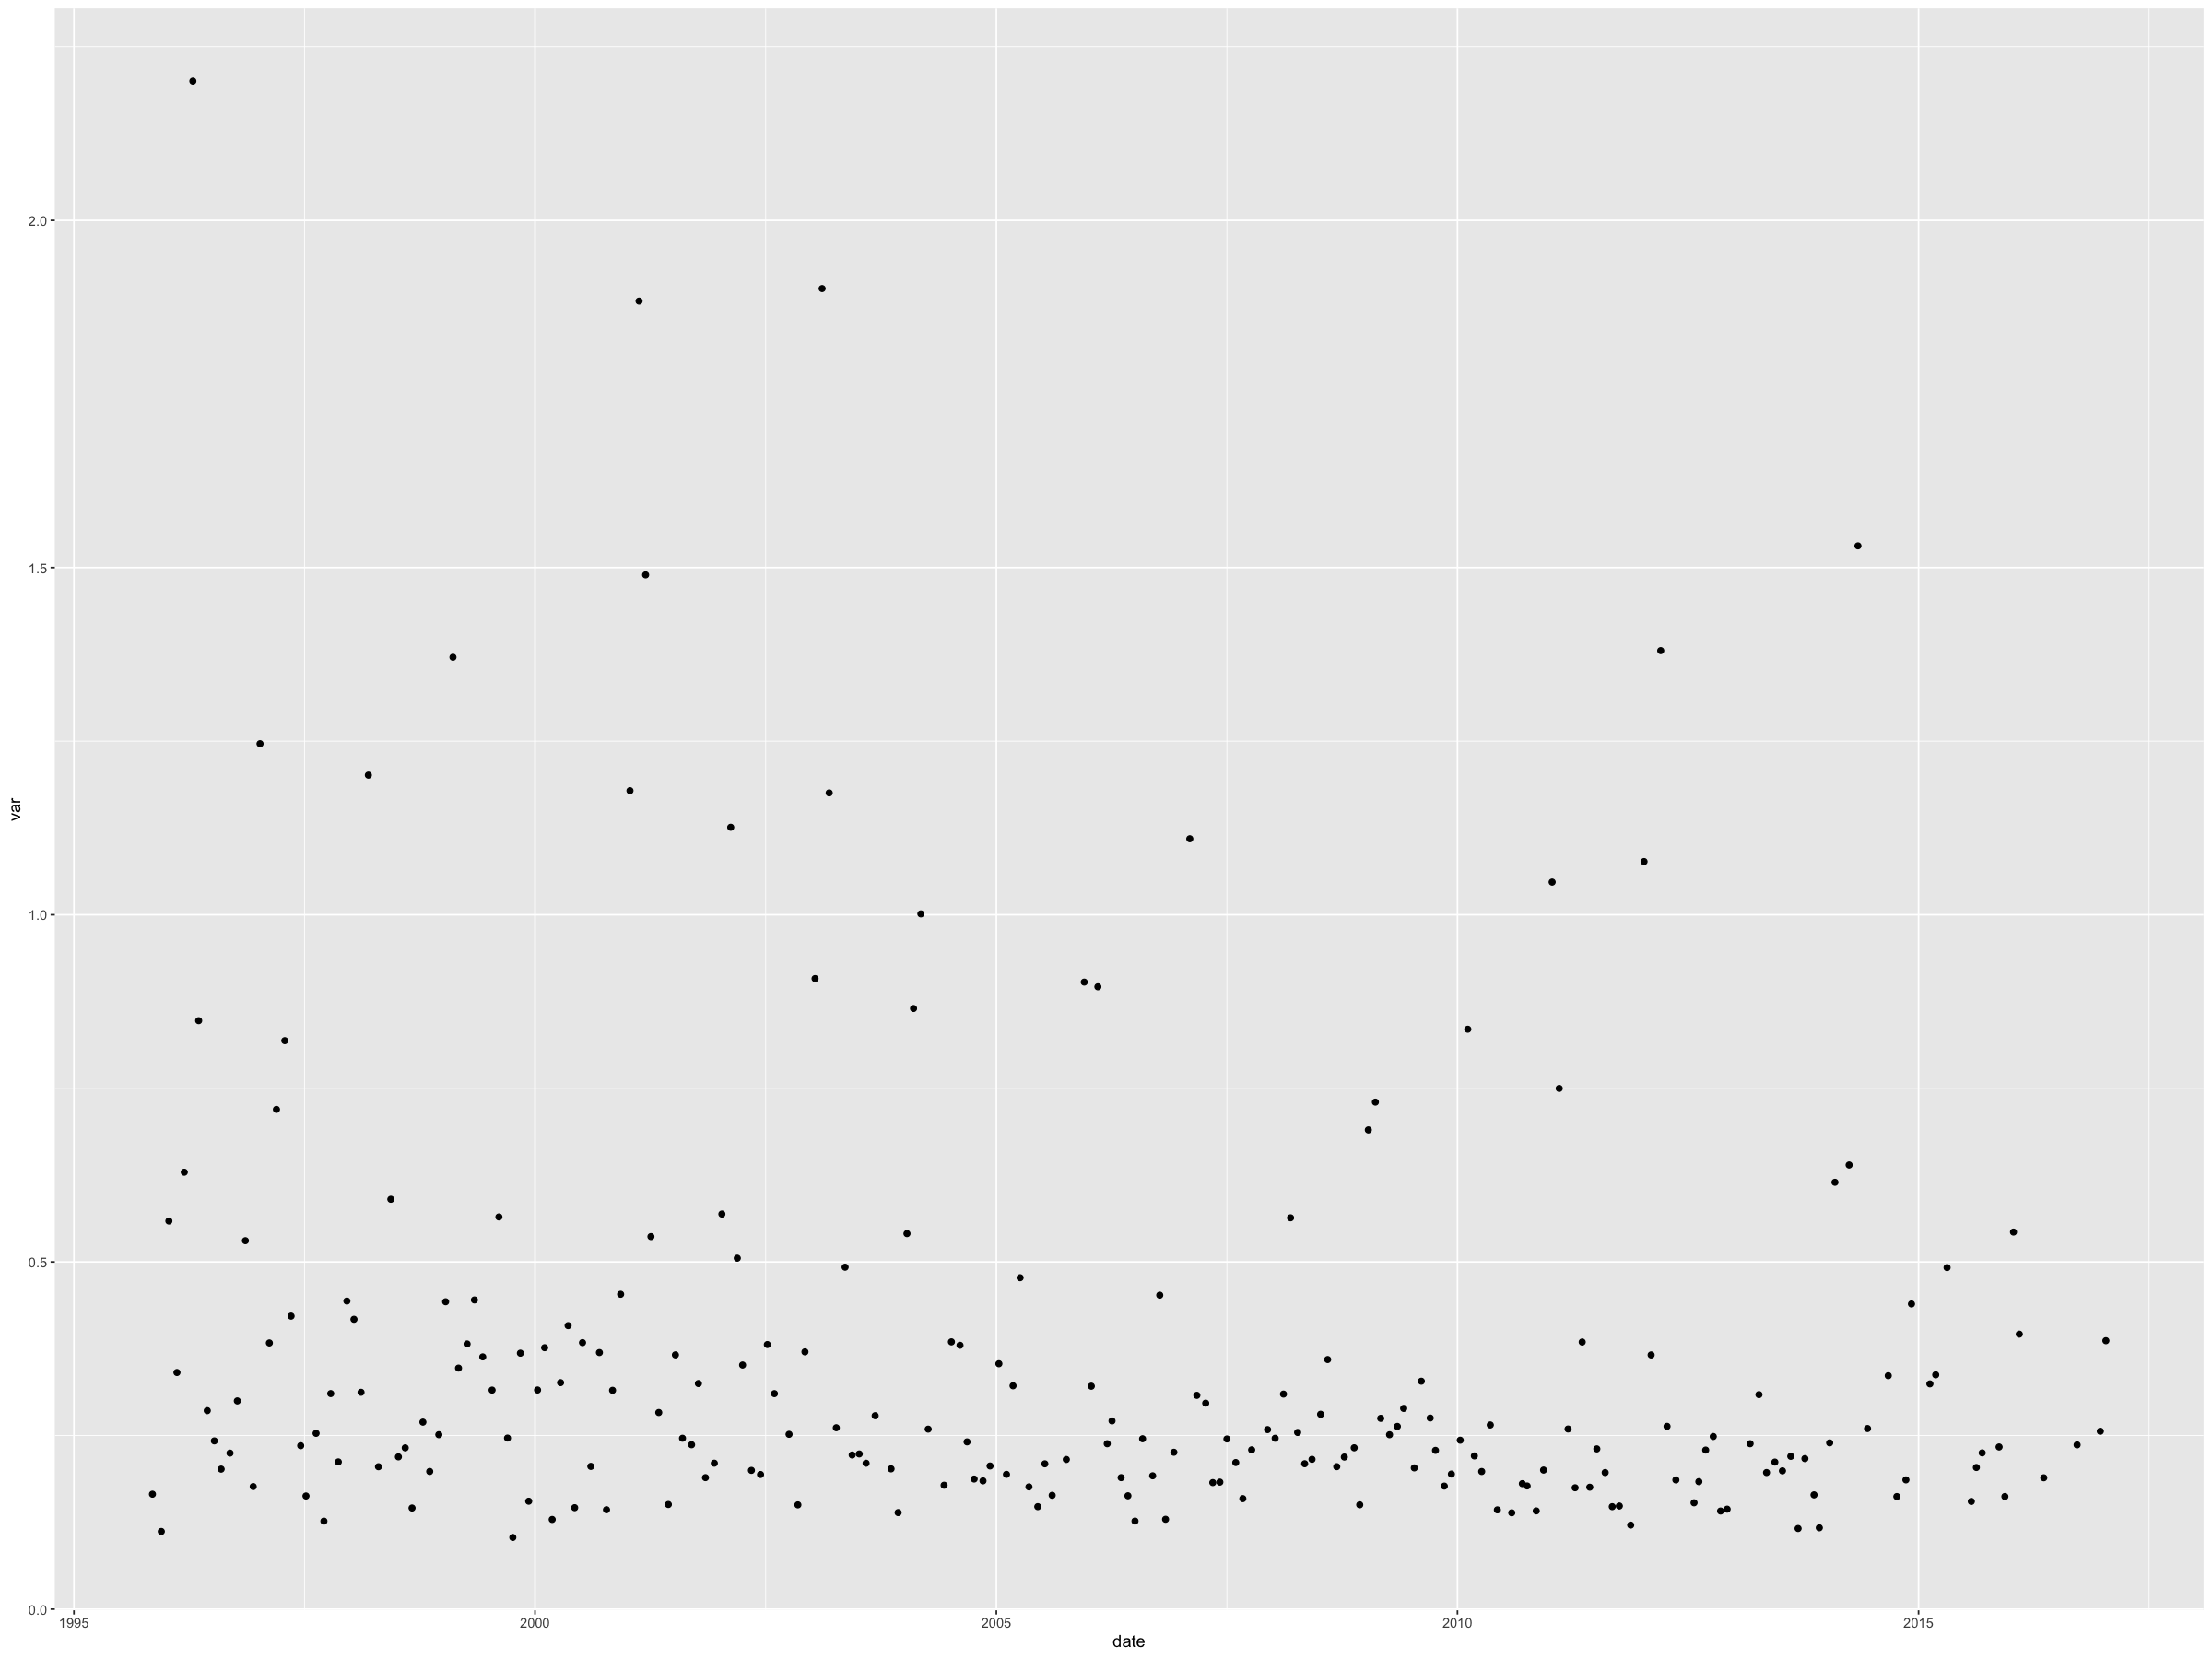

In [59]:
ggplot(interpolateNiskin("Chlorophyll", 'oce-rr', depth_to=100, noofNA=40), aes(x=date, y=var)) + geom_point()

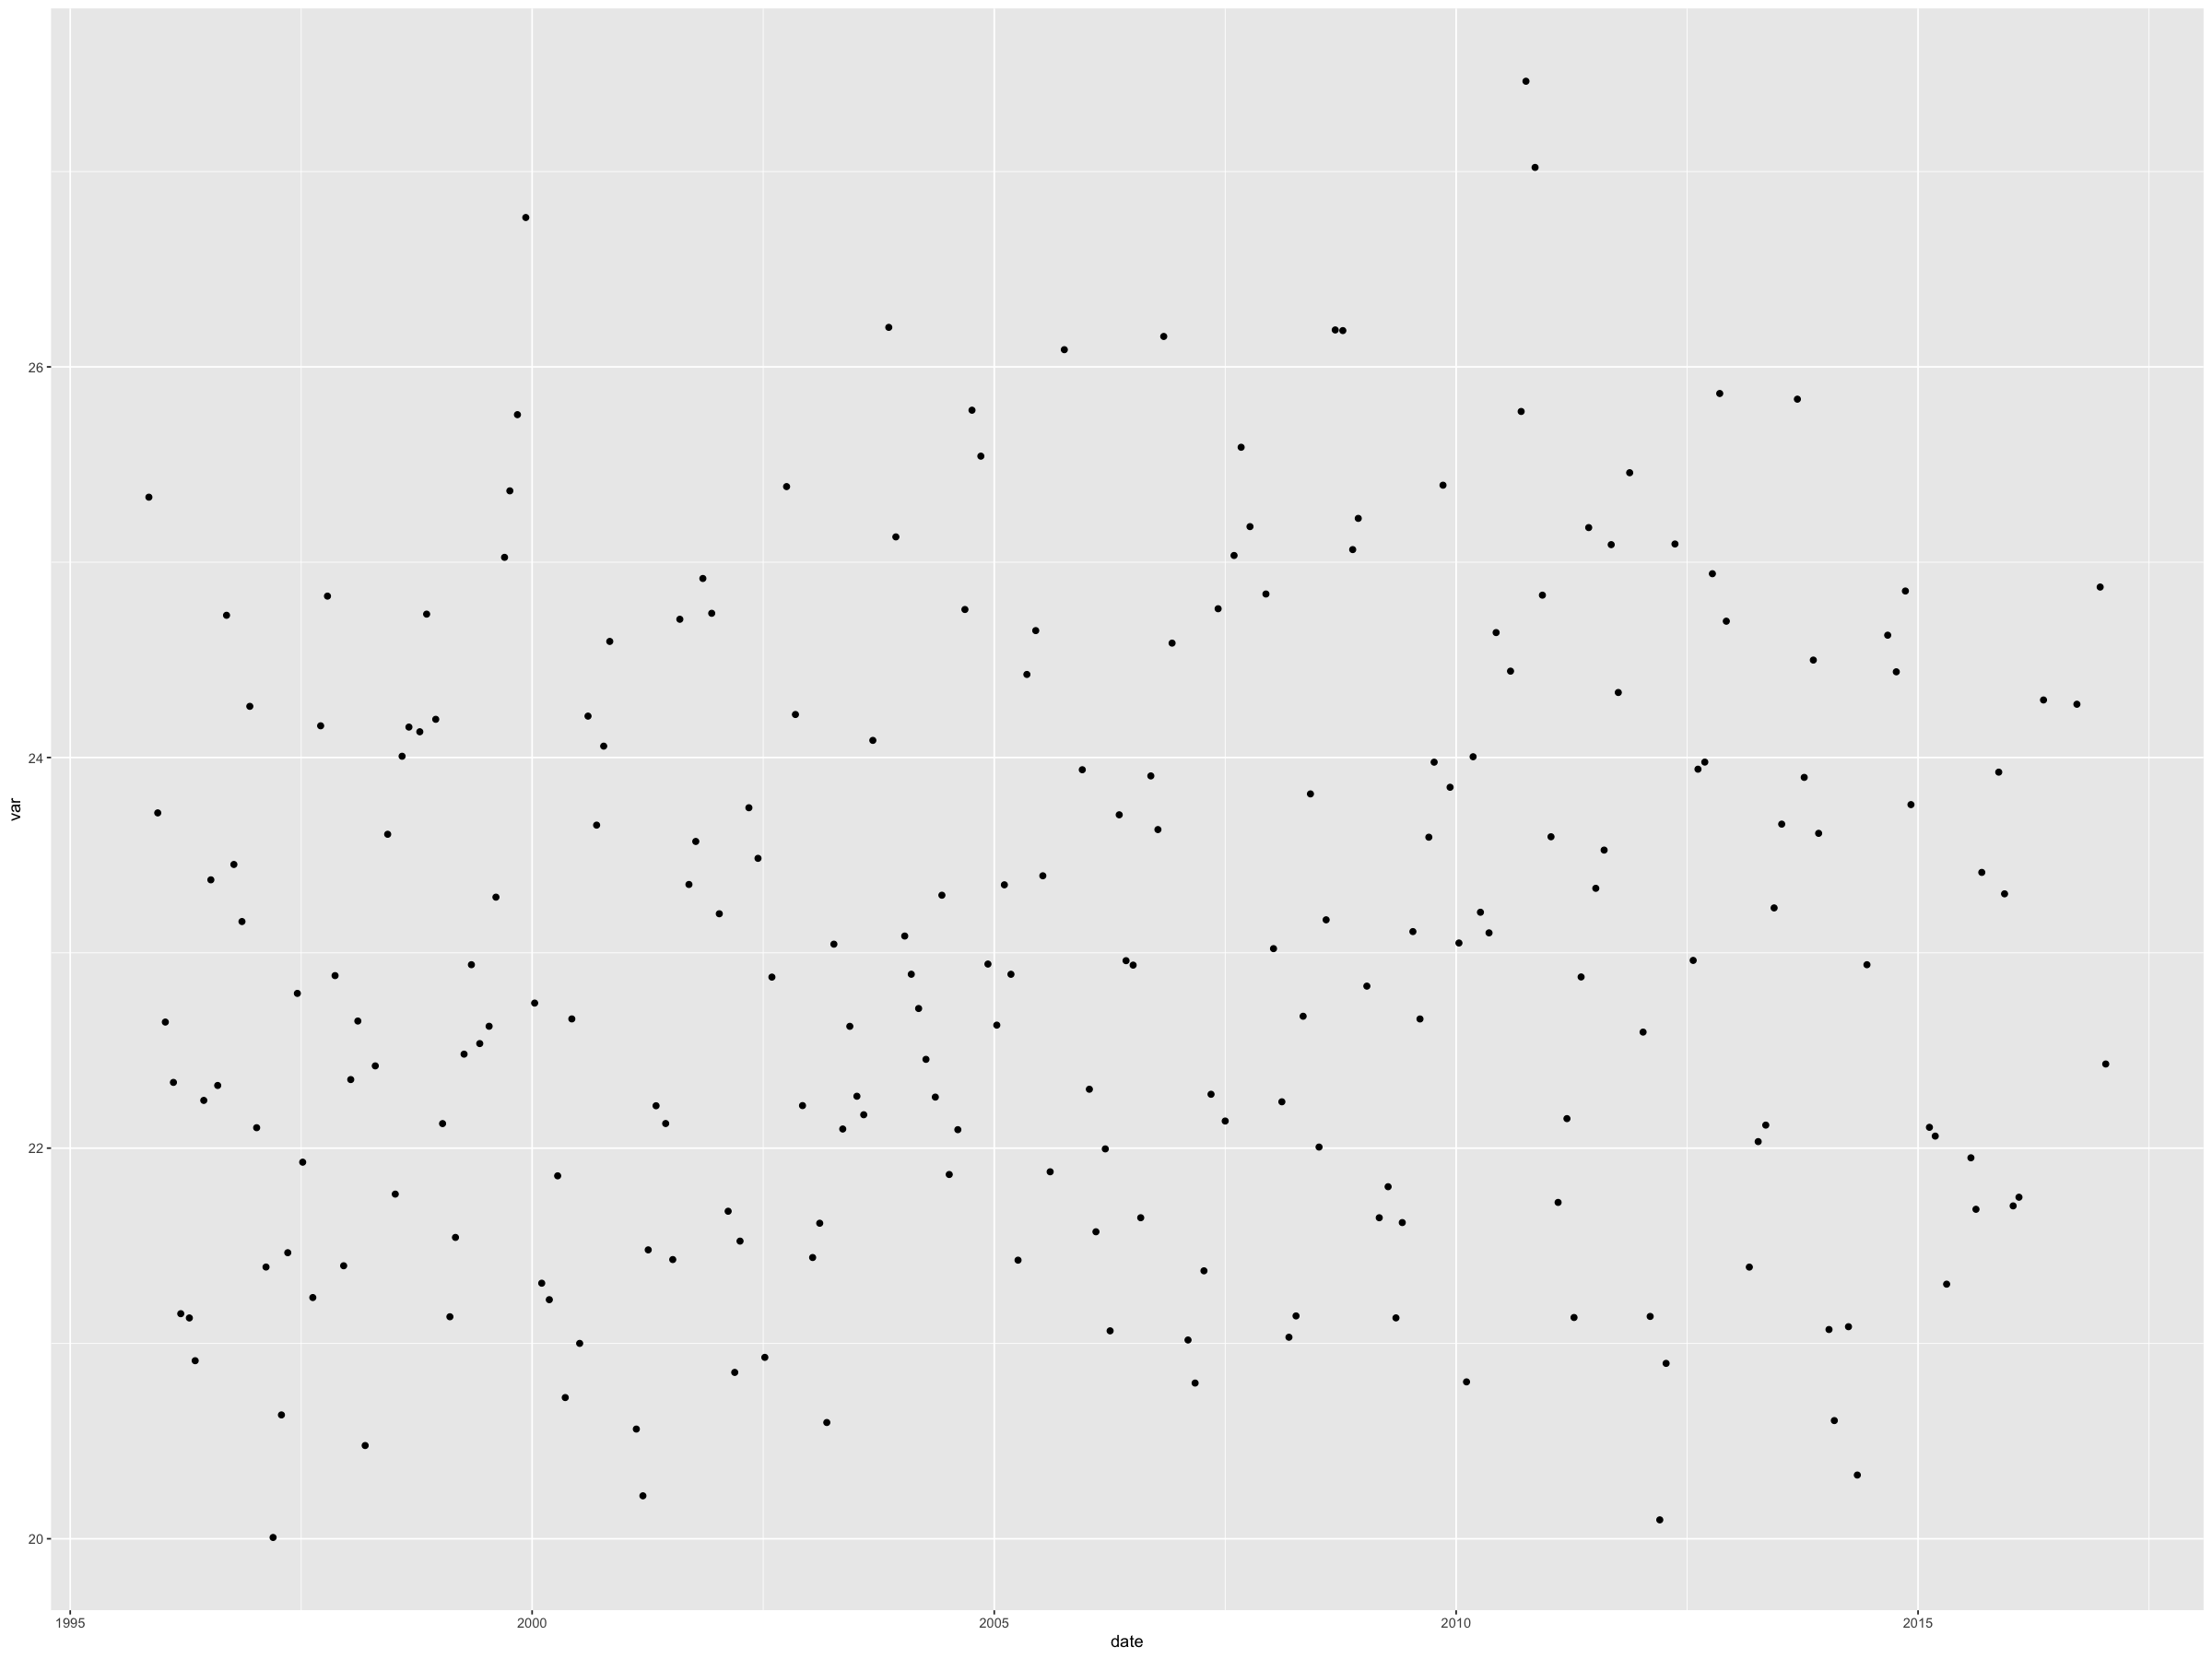

In [81]:
ggplot(interpolateNiskin("Temperature", 'oce-rr', depth_to=100, noofNA=20), aes(x=date, y=var)) + geom_point()

In [79]:
length(interpolateNiskin("Temperature", 'oce-rr', depth_to=100, noofNA=20)$var)

[1] 225

# interpolate niskin_ds

In [28]:
# Function to read specific verfication type from dataset

prepdataframe <- function(variable='', datasource='niskin'){
    if(datasource=='niskin'){
    DF <- niskin_ds
    DF$date <- as.Date(DF$DATE, format="%Y-%m-%d")
    DF$depth <- DF$Depth_real
    #print(names(DF))
        
    VarDF <- DF %>%
      select(date, all_of(variable), depth) %>%
      gather(key='key',value = "value", -date, -depth)
    #head(VarDF)
    }
    
    return(VarDF)
}

In [29]:
# Interpolate
interpolateDF <- function(DF,func='oce-rr'){
    zz <- seq(0, 200, 1)
    
    if(func=='linear'){
        IntDF <- DF %>%
            group_by(date) %>%
            filter(sum(!is.na(value))>1) %>%
            do(data.frame(value_int = with(.,approx(depth, value, zz)), depth = zz)) 
        
        IntDF <- IntDF %>% 
              rename(
                value_int = value_int.y
                )
        IntDF$value_int.x <- NULL
        }
    
    else if(func=='oce-rr'){
        IntDF <- DF %>%
            group_by(date) %>%
            do(data.frame(value_int = with(.,oceApprox(depth, value, zz, "rr")), depth = zz)) 
        }
    
    return(IntDF)
}

In [93]:
interpolateNiskin <- function(var, int_func='linear', depth_to=100, depth_from=0, noofNA=20){
 
    niskin_dat <- prepdataframe(var)
    
    #rint(c(max(niskin_dat$value, na.rm=TRUE), which.max(niskin_dat$value)))
    #print(mean(niskin_dat$value, na.rm=TRUE))

    niskin_int <- interpolateDF(niskin_dat, int_func)   
    
    niskin_sum <- niskin_int %>%
        group_by(date) %>%
        filter(depth_from<=depth & depth<=depth_to) %>%
        filter(sum(is.na(value_int))<noofNA) %>%
        summarize(value_sum = sum(value_int, na.rm=TRUE), 
                  var = mean(value_int, na.rm=TRUE),
                  #value_intgrtd = value_mean * 100,
                  NAs = sum(is.na(value_int)), .groups="keep")
    
    niskin_sum_monthly <- niskin_sum %>%
          mutate(time_month = format(date, format="%m-%Y"))

    
    return(niskin_sum_monthly)
}

In [100]:
#interpolateNiskin('Chlorophyll', 'oce-rr', depth_to=100, noofNA=20)

In [65]:
niskin_numeric = c( 
                'NO3_UDO',
                'PO4_UDO',
                'SiO4_UDO',
                'NH4_USF',
                'NO2_USF',
                'NO3_NO2_USF',
                'PO4_USF',
                'SiO4_USF',
                'pH_corrected',
                'Salinity_bottles',
                'Temperature',
                'Sigma_t',
                'PrimaryProductivity',
                'Chlorophyll',
                'Phaeopigments')

In [104]:
require(purrr)
require(dplyr)

niskin_temp_store = list()

for (variable in niskin_numeric) {
    #print(variable)
    dat <- interpolateNiskin(variable, 'oce-rr')
    #print(tail(dat))
    niskin_temp_store[[variable]] <- data.frame(dat_var = dat$var, time_month = dat$time_month)
    names(niskin_temp_store[[variable]])[1] <- variable
    #print(tail(niskin_temp_store[[variable]]))
}

niskin_intrp_100m <- niskin_temp_store %>% 
    reduce(full_join, by = "time_month")

In [105]:
str(niskin_intrp_100m)

'data.frame':	229 obs. of  16 variables:
 $ NO3_UDO            : num  0.881 3.092 7.534 6.834 6.538 ...
 $ time_month         : chr  "11-1995" "12-1995" "01-1996" "02-1996" ...
 $ PO4_UDO            : num  0.0594 0.2094 0.3027 0.3221 0.3329 ...
 $ SiO4_UDO           : num  2.12 3.86 4.86 4.05 5.15 ...
 $ NH4_USF            : num  NA NA NA NA NA NA NA NA NA NA ...
 $ NO2_USF            : num  NA NA NA NA NA NA NA NA NA NA ...
 $ NO3_NO2_USF        : num  NA NA NA NA NA NA NA NA NA NA ...
 $ PO4_USF            : num  NA NA NA NA NA NA NA NA NA NA ...
 $ SiO4_USF           : num  NA NA NA NA NA NA NA NA NA NA ...
 $ pH_corrected       : num  NA 8.01 7.99 7.96 NA ...
 $ Salinity_bottles   : num  36.8 NA 36.9 36.9 36.8 ...
 $ Temperature        : num  25.3 23.7 22.6 22.3 21.1 ...
 $ Sigma_t            : num  24.6 25.1 25.5 25.6 25.8 ...
 $ PrimaryProductivity: num  NA 0.451 1.976 1.111 1.513 ...
 $ Chlorophyll        : num  0.166 0.111 0.559 0.341 0.623 ...
 $ Phaeopigments      : num  0.24

In [106]:
require(purrr)
require(dplyr)

niskin_temp_store = list()

for (variable in niskin_numeric) {
    #print(variable)
    dat <- interpolateNiskin(variable, 'oce-rr', depth_to=35)
    niskin_temp_store[[variable]] <- data.frame(dat_var = dat$var, time_month = dat$time_month)
    names(niskin_temp_store[[variable]])[1] <- variable
    #print(head(niskin_temp_store[[variable]]))
}

niskin_intrp_35m <- niskin_temp_store %>% 
    reduce(full_join, by = "time_month")


In [107]:
niskin_temp_store = list()

for (variable in niskin_numeric) {
    #print(variable)
    dat <- interpolateNiskin(variable, 'oce-rr', depth_from=35, depth_to=100)
    niskin_temp_store[[variable]] <- data.frame(dat_var = dat$var, time_month = dat$time_month)
    names(niskin_temp_store[[variable]])[1] <- variable
    #print(head(niskin_temp_store[[variable]]))
}

niskin_intrp_35m_to100m <- niskin_temp_store %>% 
    reduce(full_join, by = "time_month")

# GET NISKIN WITH ACTUAL DATE

In [10]:
niskin_temp_store = list()

for (variable in niskin_numeric) {
    print(variable)
    dat <- interpolateNiskin(variable)
    niskin_temp_store[[variable]] <- data.frame(dat_var = dat$var, date = dat$date)
    names(niskin_temp_store[[variable]])[1] <- variable
    #print(head(niskin_temp_store[[variable]]))
}

[1] "O2_ml_L"
[1] "O2_umol_kg"
[1] "NO3_UDO"
[1] "PO4_UDO"
[1] "SiO4_UDO"
[1] "NH4_USF"
[1] "NO2_USF"
[1] "NO3_NO2_USF"
[1] "PO4_USF"
[1] "SiO4_USF"
[1] "pH"
[1] "Alkalinity_mol_kg"
[1] "Alkalinity_umol_kg"
[1] "TCO2"
[1] "fCO2"
[1] "pH_corrected"
[1] "TCO2_corrected"
[1] "fCO2_corrected"
[1] "Salinity_bottles"
[1] "Salinity_CTD"
[1] "Temperature"
[1] "Sigma_t"
[1] "TPP"
[1] "PIP"
[1] "POC_ug_kg"
[1] "PON_ug_kg"
[1] "POC_ug_L"
[1] "PN_ug_L"
[1] "C_N_particulate"
[1] "DON"
[1] "DOP"
[1] "DOC"
[1] "TOC"
[1] "PrimaryProductivity"
[1] "Chlorophyll"
[1] "Phaeopigments"
[1] "Total_Prokaryotes"
[1] "Bact_Biomass_mgC_m3"
[1] "Bact_Biomass_uMC"


In [11]:
niskin_intrp_wDATE <- niskin_temp_store %>% 
    reduce(full_join, by = "date")

In [12]:
niskin_intrp_wDATE

O2_ml_L,date,O2_umol_kg,NO3_UDO,PO4_UDO,SiO4_UDO,NH4_USF,NO2_USF,NO3_NO2_USF,PO4_USF,⋯,DON,DOP,DOC,TOC,PrimaryProductivity,Chlorophyll,Phaeopigments,Total_Prokaryotes,Bact_Biomass_mgC_m3,Bact_Biomass_uMC
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.066699,1995-11-08,177.2776,0.9217535,0.06162603,2.127115,NA,NA,NA,NA,⋯,NA,NA,78.70598,NA,NA,0.1793046,0.2700351,NA,NA,NA
3.438551,1995-12-13,149.8085,3.0948845,0.21142690,3.868919,NA,NA,NA,NA,⋯,NA,NA,NA,NA,0.4826918,0.1150949,0.1636278,0.7002847,2.131909,0.1776498
3.405264,1996-01-12,148.3119,7.5116266,0.30383795,4.868135,NA,NA,NA,NA,⋯,NA,NA,81.52567,NA,2.0569311,0.5825762,0.3451711,3.0429052,9.928947,0.8274119
3.304298,1996-02-13,143.9005,6.8777834,0.32541078,4.052312,NA,NA,NA,NA,⋯,NA,NA,70.76477,NA,1.2175528,0.3497634,0.2855399,2.5915307,8.455257,0.7046181
3.412656,1996-03-13,148.5819,6.5870977,0.33615601,5.161176,NA,NA,NA,NA,⋯,NA,NA,NA,NA,1.5397245,0.6365204,0.3778061,NA,NA,NA
3.569975,1996-04-16,155.4296,6.7700114,0.36042125,3.744388,NA,NA,NA,NA,⋯,NA,NA,89.78809,NA,0.9200121,2.2452814,1.3622393,1.6907867,5.531503,0.4609772
3.011871,1996-05-09,131.1264,8.8536038,0.41044416,4.817140,NA,NA,NA,NA,⋯,NA,NA,NA,NA,5.4573471,0.8740617,0.4288778,4.2037764,13.761397,1.1467797
3.631876,1996-06-12,158.1693,7.7127451,0.28324421,3.655185,NA,NA,NA,NA,⋯,NA,NA,81.29121,NA,1.0564614,0.2943889,0.2438052,5.0894137,16.604926,1.3837328
3.322255,1996-07-10,144.7358,5.8328983,0.33031846,2.519367,NA,NA,NA,NA,⋯,NA,NA,69.40608,NA,0.8158177,0.2510180,0.3100330,NA,NA,NA


In [1]:
head(niskin_intrp_wDATE)

ERROR: Error in head(niskin_intrp): Objekt 'niskin_intrp' nicht gefunden


In [13]:
niskin_intrp_wDATE$NO3_USF = niskin_intrp_wDATE$NO3_NO2_USF - niskin_intrp_wDATE$NO2_USF

niskin_merged_nuts_wDATE <- niskin_intrp_wDATE %>%
    group_by(date) %>%
    mutate(NO3_merged =  mean(c(NO3_UDO, NO3_USF), na.rm=TRUE),
          PO4_merged = mean(c(PO4_UDO, PO4_USF), na.rm=TRUE),
          SiO4_merged = mean(c(SiO4_UDO, SiO4_USF), na.rm=TRUE))

In [14]:
write.csv(niskin_merged_nuts_wDATE, "../DATA/Niskin_mergedNutrients_wDATE.csv")

# NOW:
- join nutrient data into single column for NO2, NO3, NO3_NO2, PO4, SiO4, NH4
- export to csv to merge later

In [108]:
names(niskin_intrp_100m)

[1] "NO3_UDO"             "time_month"          "PO4_UDO"            
 [4] "SiO4_UDO"            "NH4_USF"             "NO2_USF"            
 [7] "NO3_NO2_USF"         "PO4_USF"             "SiO4_USF"           
[10] "pH_corrected"        "Salinity_bottles"    "Temperature"        
[13] "Sigma_t"             "PrimaryProductivity" "Chlorophyll"        
[16] "Phaeopigments"

In [109]:
niskin_intrp_100m$NO3_USF = niskin_intrp_100m$NO3_NO2_USF - niskin_intrp_100m$NO2_USF
niskin_intrp_35m$NO3_USF = niskin_intrp_35m$NO3_NO2_USF - niskin_intrp_35m$NO2_USF
niskin_intrp_35m_to100m$NO3_USF = niskin_intrp_35m_to100m$NO3_NO2_USF - niskin_intrp_35m_to100m$NO2_USF

In [110]:
write.csv(niskin_intrp_100m, "../DATA/January/Niskin_qchecked_100m.csv")
write.csv(niskin_intrp_35m, "../DATA/January/Niskin_qchecked_35m.csv")
write.csv(niskin_intrp_35m_to100m, "../DATA/January/Niskin_qchecked_35to100m.csv")